In [1]:
import cirq
import numpy as np
import tensorflow_quantum as tfq
import pandas as pd

from qite import QITE
from circuit import build_ansatz, initialize_ansatz_symbols
from problem import build_ising_model_hamiltonian
from utils import evaluate_exact_state, plot_density_matrix_heatmap, get_ancillary_qubits, save_circuit_to_svg

/home/lleevi/workspaces/QC/tfq-varqbm/qite.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Define global variables

Define global variables such as temperature used for determining evolution time

In [2]:
kBT = 1
evolution_time = 1 / (2 * kBT)
n_hamiltonian_qubits = 4
n_timesteps = 100

## Generate Hamiltonian

We generate a Hamiltonian of transverse field Isisng model having 4 qubits "fully connected" and pauliterm coefficients sampled from uniform distribution of -2 to 2.

In [3]:
hamiltonian, problem_qubits = build_ising_model_hamiltonian([n_hamiltonian_qubits], random=True, random_low = -2, random_high=2)

In [4]:
print(hamiltonian)

-0.866*Z((0, 0))*Z((1, 0))-0.138*Z((0, 0))*Z((2, 0))+0.003*Z((0, 0))*Z((3, 0))-0.520*Z((1, 0))*Z((2, 0))+1.228*Z((1, 0))*Z((3, 0))-0.569*Z((2, 0))*Z((3, 0))+0.276*Z((0, 0))+1.756*X((0, 0))-1.586*Z((1, 0))-0.558*X((1, 0))-0.216*Z((2, 0))+1.907*X((2, 0))-1.444*Z((3, 0))+1.736*X((3, 0))


### Exact thermal state

Exact thermal state analytically by solving matrix exponential.

In [5]:
exact_state = evaluate_exact_state(hamiltonian, evolution_time)

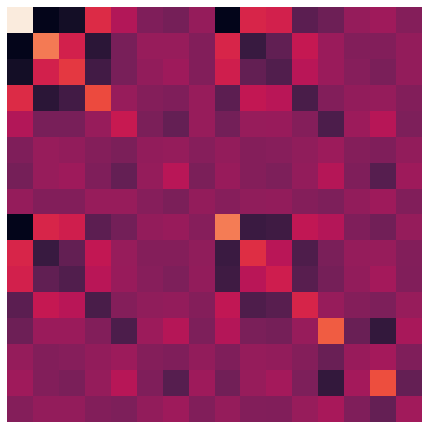

In [6]:
plot_density_matrix_heatmap([exact_state], show = True, size = 6)

## Define a variational circuit for VarQITE

Define a variational circuit for VarQITE having good represenationa cababilities.

In [7]:
n_layers = 3
rotations = [cirq.ry, cirq.rz]
entanglers = [cirq.CNOT]
pattern = "chain"
ancillary_qubits = get_ancillary_qubits(problem_qubits)
qubits = [*problem_qubits, *ancillary_qubits]

circuit, symbol_names = build_ansatz(
    qubits, n_layers, rotations, entanglers, pattern
)
initial_symbol_values = initialize_ansatz_symbols(
    len(qubits),
    n_layers,
    len(rotations),
    0,
    np.pi / 2,
    len(entanglers),
    pattern,
)

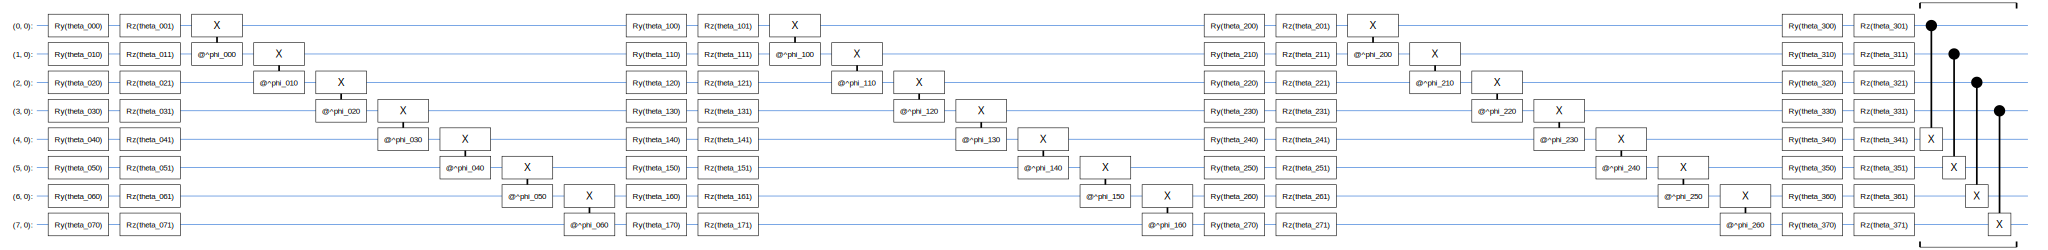

In [9]:
save_circuit_to_svg(circuit, show = True)

## Run variational quantum imaginary time evolution (VarQITE)

In [10]:
qite = QITE(verbose = 3)
final_symbol_values, final_state, metrics = qite.run(
    circuit,
    hamiltonian,
    symbol_names,
    initial_symbol_values,
    evolution_time,
    exact_state,
    n_timesteps=n_timesteps
)

QITE:   0%|          | 0/100 [00:00<?, ?it/s]

QITE timestep   0: [energy = 0.000, fidelity = 0.502, quantum_relative_entropy = 1.126, trace_distance = 0.599]
QITE timestep   1: [energy = 0.000, fidelity = 0.511, quantum_relative_entropy = 1.098, trace_distance = 0.593]
QITE timestep   2: [energy = -0.087, fidelity = 0.520, quantum_relative_entropy = 1.071, trace_distance = 0.586]
QITE timestep   3: [energy = -0.174, fidelity = 0.529, quantum_relative_entropy = 1.045, trace_distance = 0.580]
QITE timestep   4: [energy = -0.260, fidelity = 0.538, quantum_relative_entropy = 1.019, trace_distance = 0.573]
QITE timestep   5: [energy = -0.346, fidelity = 0.547, quantum_relative_entropy = 0.993, trace_distance = 0.566]
QITE timestep   6: [energy = -0.431, fidelity = 0.556, quantum_relative_entropy = 0.968, trace_distance = 0.560]
QITE timestep   7: [energy = -0.516, fidelity = 0.565, quantum_relative_entropy = 0.943, trace_distance = 0.553]
QITE timestep   8: [energy = -0.600, fidelity = 0.574, quantum_relative_entropy = 0.918, trace_dis

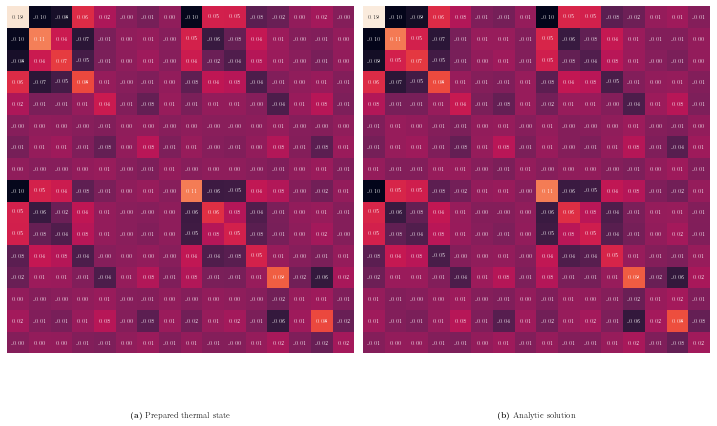

In [16]:
plot_density_matrix_heatmap([final_state, exact_state], titles = ["Prepared thermal state", "Analytic solution"], annot = True, size = 10)

In [23]:
df = pd.DataFrame.from_dict(metrics)
df.tail(20)

,time_step,energy,fidelity,quantum_relative_entropy,trace_distance
81,81,-4.874700,0.971470,0.060805,0.138071
82,82,-4.901995,0.972833,0.058476,0.135156
83,83,-4.928858,0.974130,0.056270,0.132389
84,84,-4.955300,0.975365,0.054183,0.129697
85,85,-4.981328,0.976533,0.052213,0.127079
86,86,-5.006949,0.977643,0.050357,0.124538
87,87,-5.032175,0.978690,0.048613,0.122074
88,88,-5.057012,0.979679,0.046979,0.119690
89,89,-5.081469,0.980611,0.045451,0.117386
90,90,-5.105553,0.981485,0.044030,0.115164
